In [1]:
import keras
import tensorflow as tf
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("drive/Colab Notebooks/Beach_Weather_Stations_-_Automated_Sensors.csv")
data.head()

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
0,63rd Street Weather Station,06/09/2019 04:00:00 PM,16.60,16.6,100,0.0,0.0,70.7,0.0,354,1.4,3.4,992.4,143,356.0,11.9,06/09/2019 4:00 PM,63rdStreetWeatherStation201906091600
1,Foster Weather Station,06/09/2019 04:00:00 PM,15.67,NaN,89,NaN,0.0,NaN,NaN,336,1.3,1.5,991.9,0,NaN,15.1,06/09/2019 4:00 PM,FosterWeatherStation201906091600
2,Oak Street Weather Station,06/09/2019 04:00:00 PM,18.50,16.6,83,0.0,0.0,28.8,0.0,63,0.6,0.9,993.2,103,320.0,12.0,06/09/2019 4:00 PM,OakStreetWeatherStation201906091600
3,63rd Street Weather Station,06/09/2019 03:00:00 PM,16.80,16.8,100,0.0,0.0,70.7,0.0,30,2.8,3.9,992.3,184,356.0,11.9,06/09/2019 3:00 PM,63rdStreetWeatherStation201906091500
4,Foster Weather Station,06/09/2019 03:00:00 PM,16.56,NaN,89,NaN,0.0,NaN,NaN,45,0.9,1.6,991.5,0,NaN,15.1,06/09/2019 3:00 PM,FosterWeatherStation201906091500


#### Convert the Measurement TimeStamp column to get the date time index for the timeseries

In [0]:
data['Measurement Timestamp'] =  pd.to_datetime(data['Measurement Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
data = data.set_index('Measurement Timestamp')
cols = ['Station Name', 'Measurement Timestamp Label', 'Measurement ID']
data.drop(cols, axis=1, inplace=True)

#### Missing value treatment
Resampled the data using the date time index in Hours, and used the "forward fill" method to populate the null values. The "ffill" method propagates the last valid observation forward to next valid observation.

In [4]:
df = data.resample('H').mean()
df.fillna(method="ffill",axis=0,inplace=True)
df.dropna(inplace=True)
df.sort_index(inplace=True,ascending=False)
df.shape

(36152, 14)

### Plots depicting change of all features over the period of last 4 years

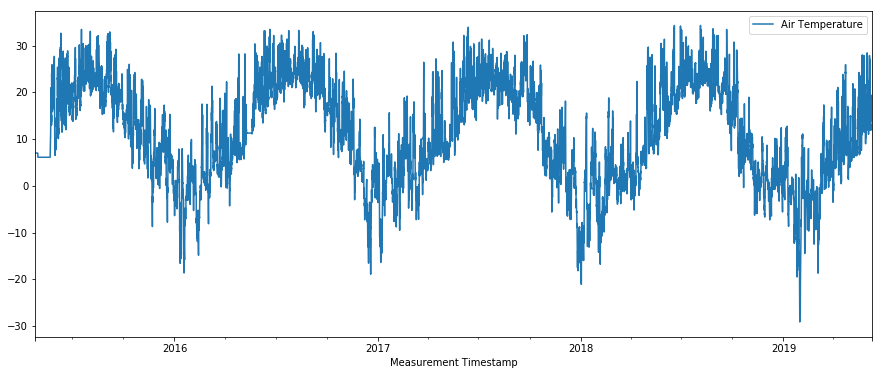

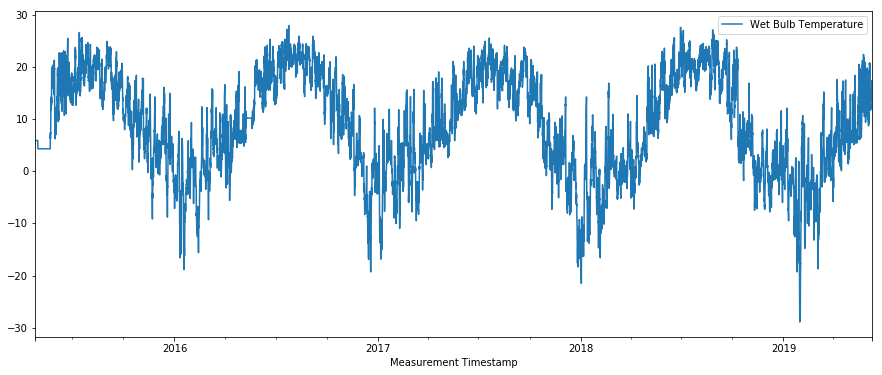

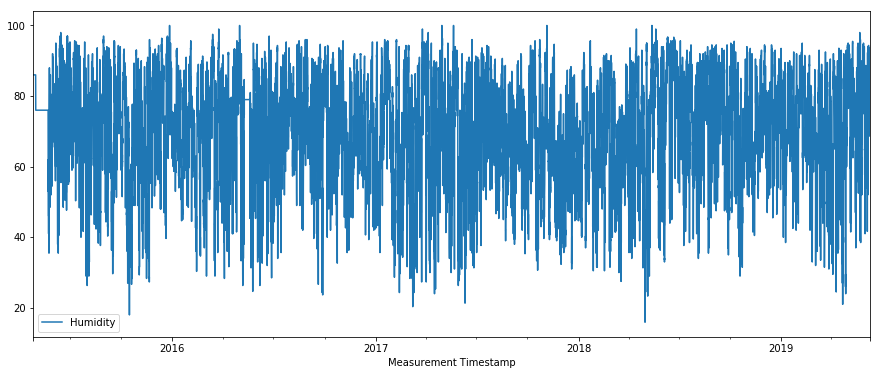

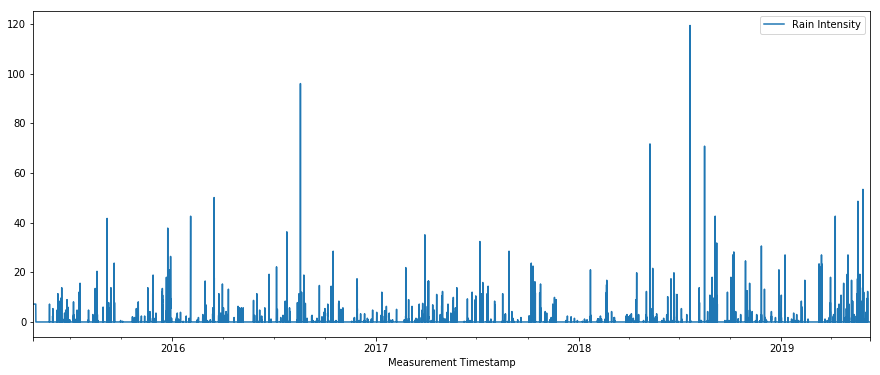

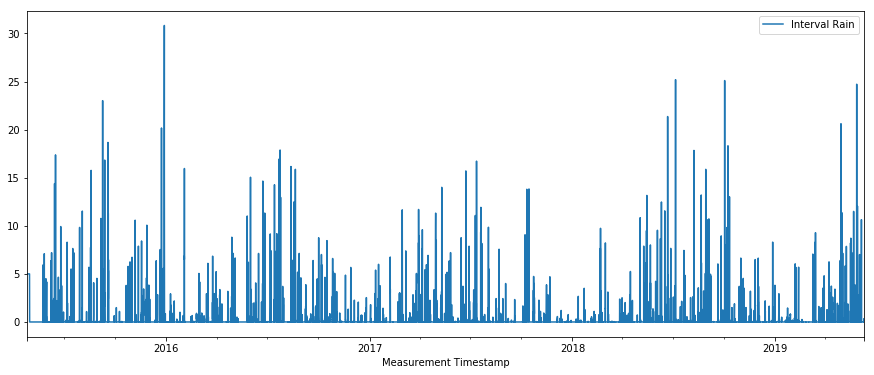

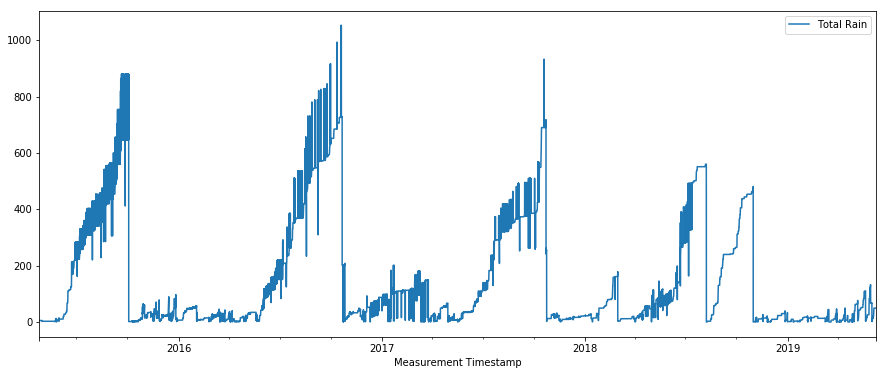

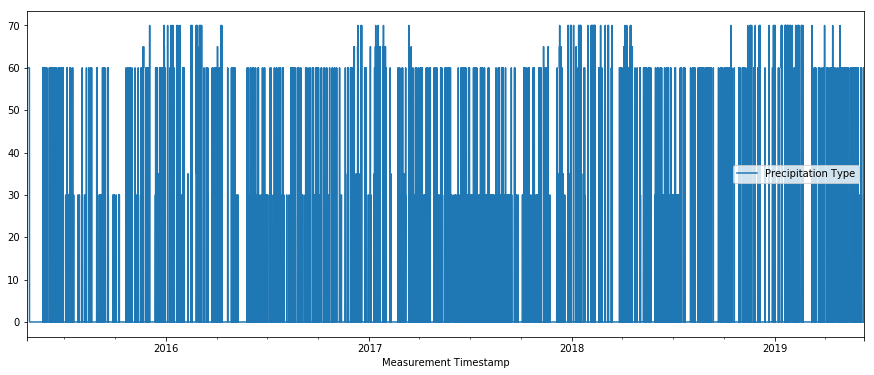

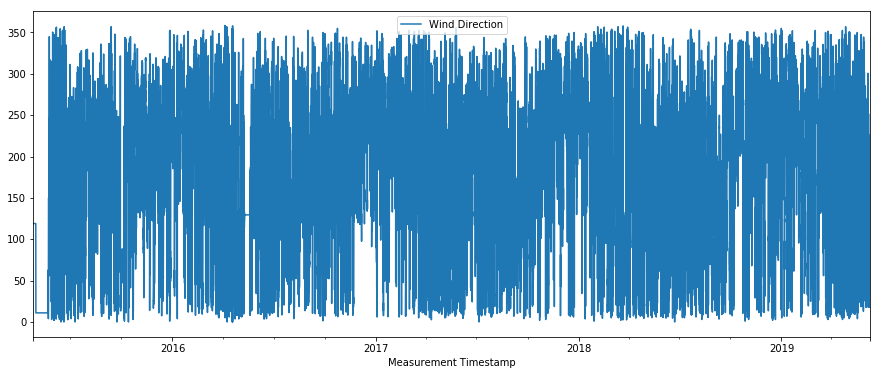

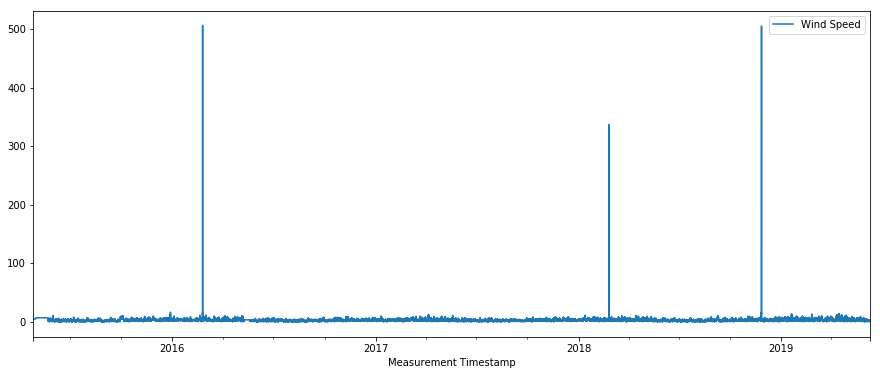

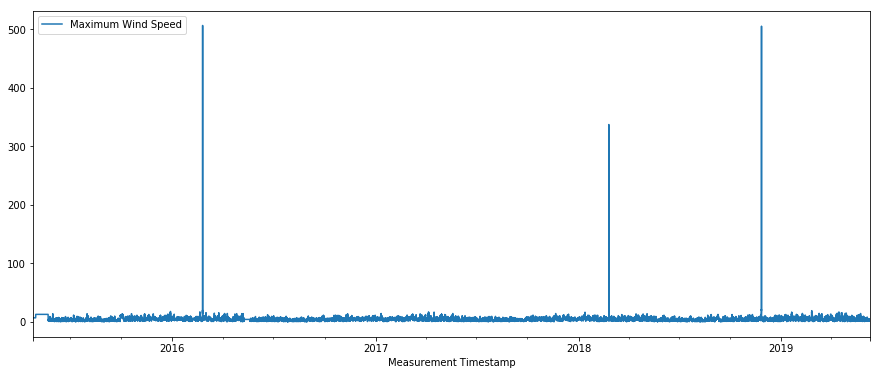

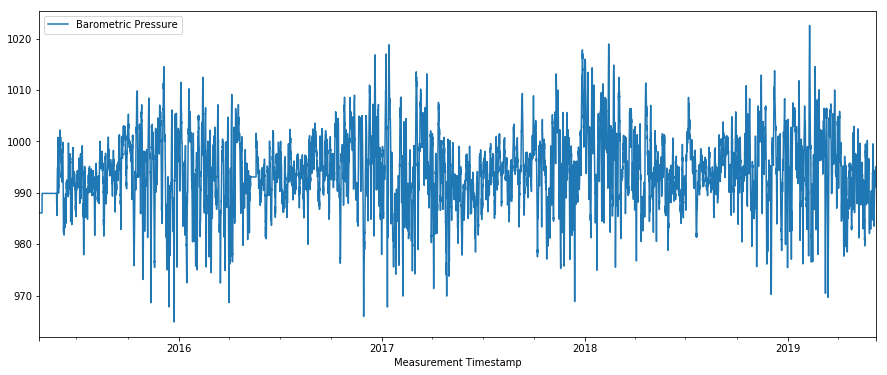

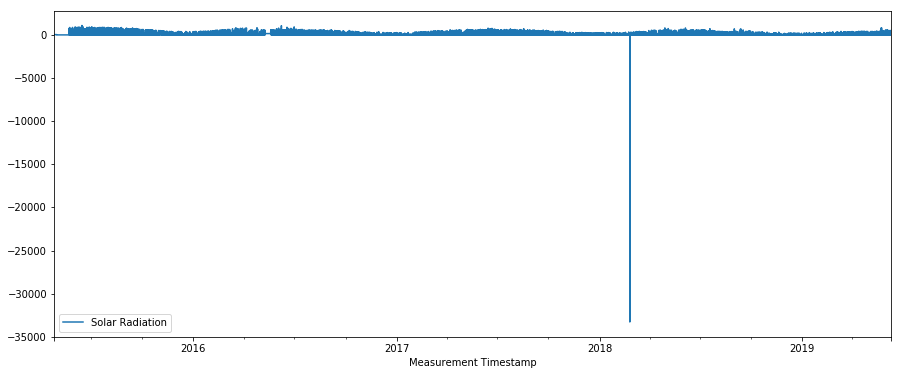

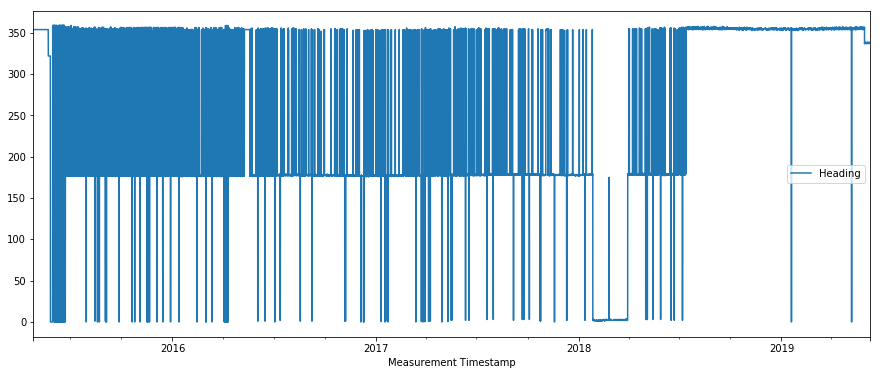

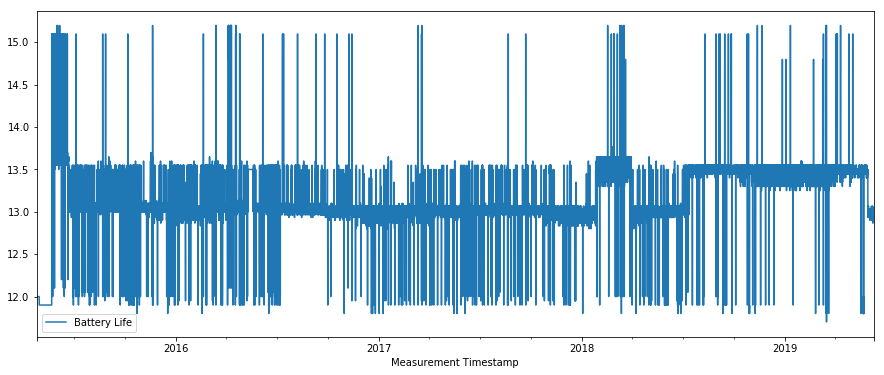

In [5]:
for i in range(len(df.columns)):
    df.iloc[:,i:i+1].plot(figsize=(15, 6))
    plt.show()

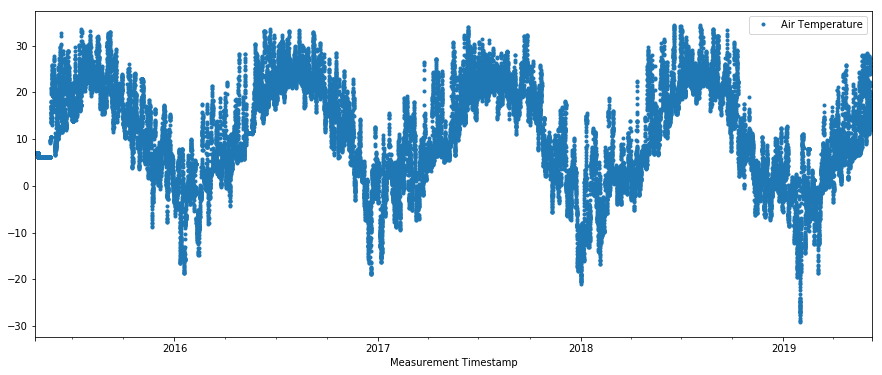

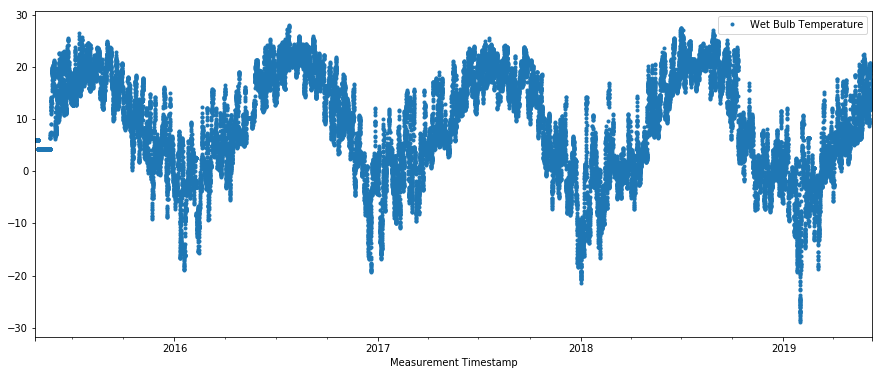

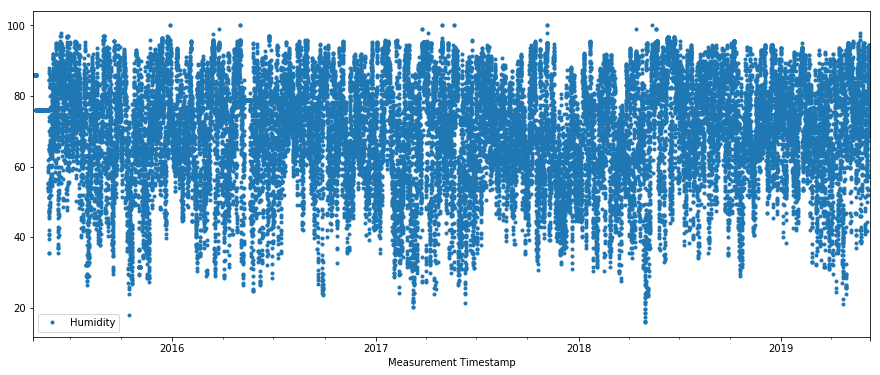

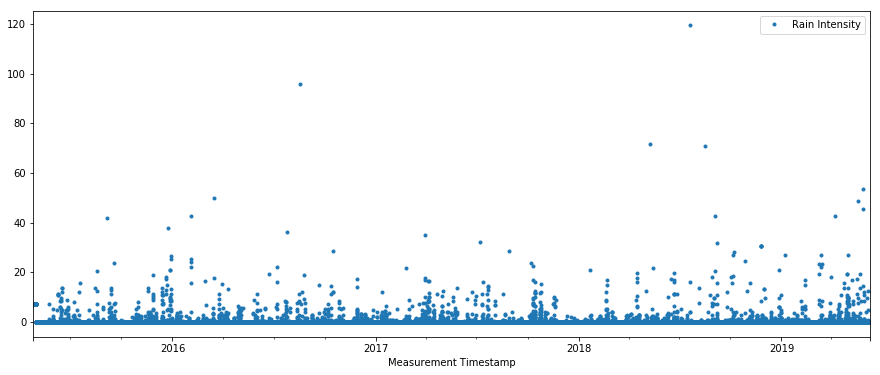

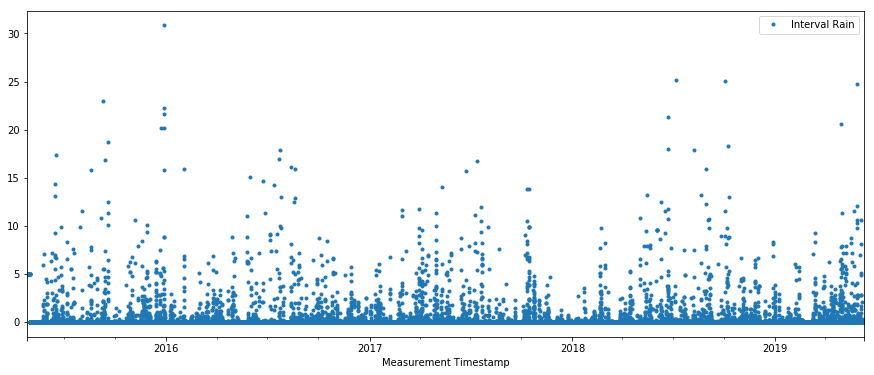

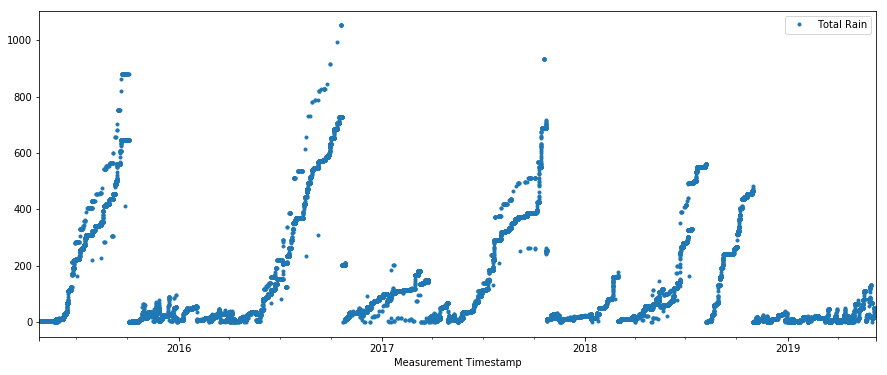

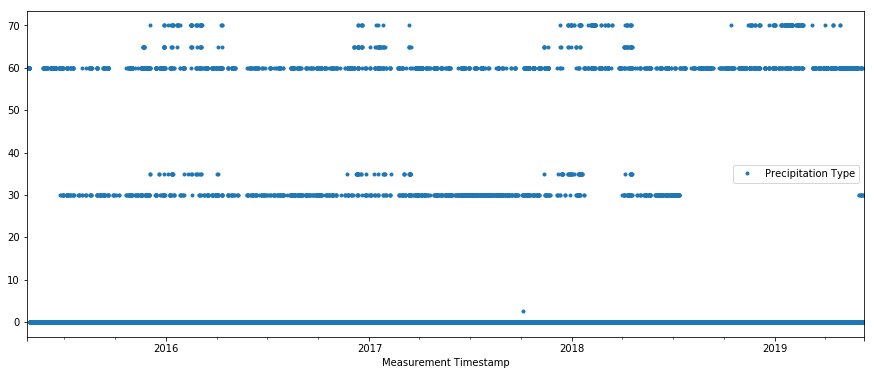

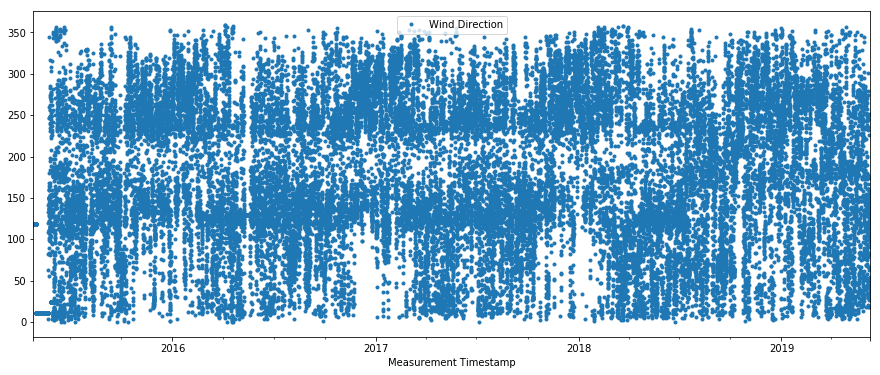

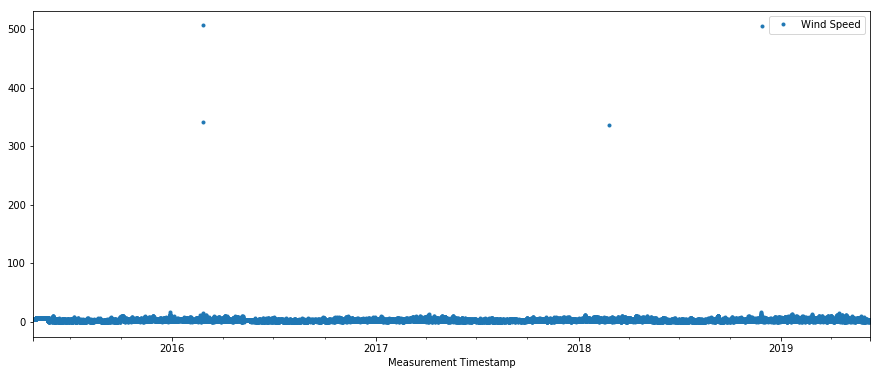

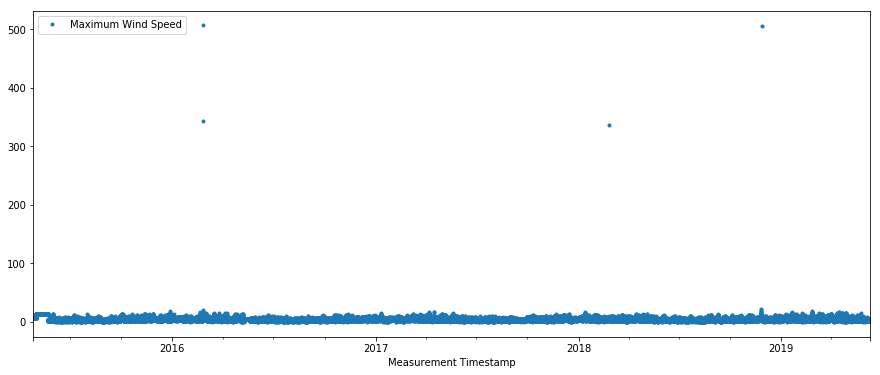

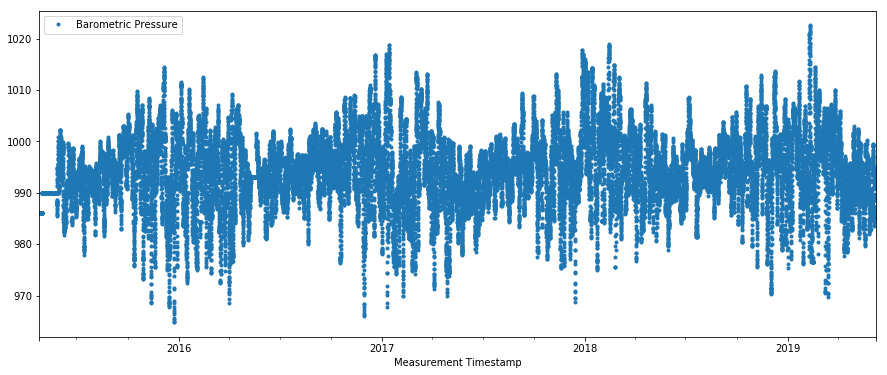

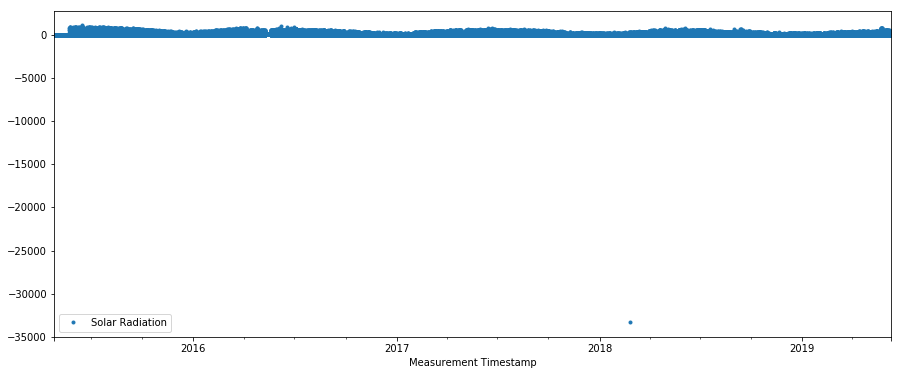

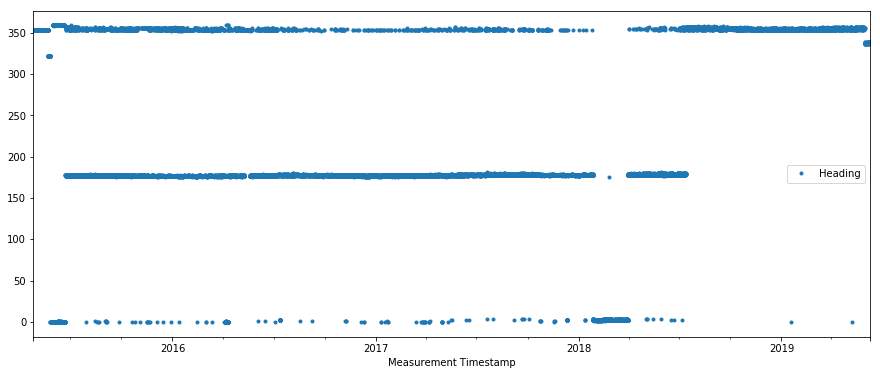

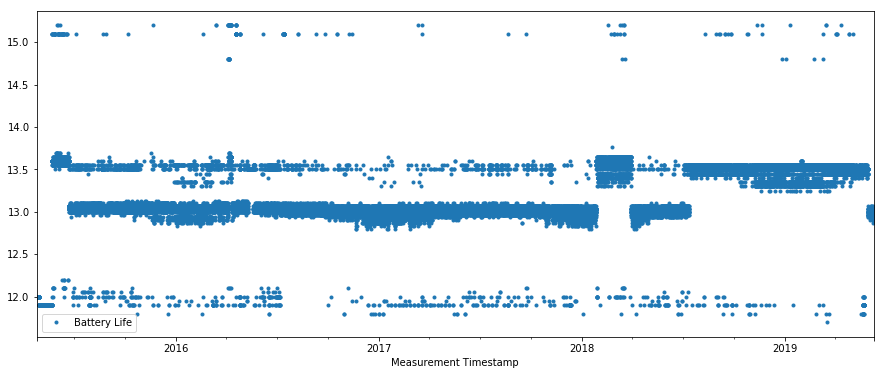

In [6]:
for i in range(len(df.columns)):
    df.iloc[:,i:i+1].plot(figsize=(15, 6),style=".")
    plt.show()

In [7]:
df.describe()

,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life
count,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000,36152.000000
mean,11.078251,8.774239,69.782179,0.214572,0.177899,144.832929,4.823869,177.310559,3.222669,4.756781,994.210693,92.252088,222.023747,13.144546
std,10.504229,9.548014,14.872349,1.843817,1.033494,187.341078,15.467917,90.307007,4.845976,5.192181,7.101939,235.563792,98.324901,0.357422
min,-29.140000,-28.900000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,964.900000,-33284.000000,0.000000,11.700000
25%,3.162500,1.850000,60.000000,0.000000,0.000000,13.600000,0.000000,113.333333,1.866667,2.800000,989.900000,1.333333,177.000000,13.000000
50%,10.866667,8.600000,71.333333,0.000000,0.000000,48.650000,0.000000,174.500000,2.833333,4.250000,994.066667,4.000000,178.000000,13.033333
75%,20.366667,17.200000,81.000000,0.000000,0.000000,239.700000,0.000000,253.333333,4.100000,6.066667,998.600000,123.666667,354.000000,13.500000
max,34.300000,27.950000,100.000000,119.400000,30.835000,1052.700000,70.000000,358.500000,506.050000,506.800000,1022.550000,1098.000000,359.000000,15.200000


### Preparing the dataset

#### Split into train, validation and test sets

In [0]:
values = df.values
train = values[:25000,:]
valid = values[25000:30000,:]
test = values[30000:,:]

#### Split into input and outputs

In [0]:
train_X, train_y = train[:, 1:], train[:, 0]
valid_X, valid_y = valid[:, 1:], valid[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

#### reshape input to be 3D [samples, timesteps, features]

In [10]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(25000, 1, 13) (25000,) (5000, 1, 13) (5000,) (6152, 1, 13) (6152,)


### A basic machine learning approach

It is useful to try simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating on the exact same data and with the exact same metric, the results will be directly comparable.

In [11]:
model = Sequential()
model.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

W0728 00:50:57.775878 140057907312512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 00:50:57.813692 140057907312512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 00:50:57.834016 140057907312512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 00:50:57.859178 140057907312512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 00:50:57.983659 140057907312512 deprecation_wrappe

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 4s - loss: 34.2786 - val_loss: 17.2997
Epoch 2/20
 - 1s - loss: 11.5628 - val_loss: 20.0097
Epoch 3/20
 - 1s - loss: 9.1060 - val_loss: 20.6660
Epoch 4/20
 - 1s - loss: 8.2023 - val_loss: 20.3157
Epoch 5/20
 - 1s - loss: 7.1327 - val_loss: 18.6113
Epoch 6/20
 - 1s - loss: 6.0886 - val_loss: 15.3729
Epoch 7/20
 - 1s - loss: 5.7428 - val_loss: 15.9801
Epoch 8/20
 - 1s - loss: 5.0942 - val_loss: 11.8117
Epoch 9/20
 - 0s - loss: 4.8797 - val_loss: 12.8463
Epoch 10/20
 - 1s - loss: 4.4493 - val_loss: 10.0731
Epoch 11/20
 - 0s - loss: 4.3610 - val_loss: 14.6268
Epoch 12/20
 - 1s - loss: 4.5337 - val_loss: 12.5250
Epoch 13/20
 - 1s - loss: 5.4772 - val_loss: 16.6392
Epoch 14/20
 - 1s - loss: 5.4328 - val_loss: 7.6988
Epoch 15/20
 - 0s - loss: 4.6892 - val_loss: 6.6686
Epoch 16/20
 - 1s - loss: 2.3526 - val_loss: 2.0844
Epoch 17/20
 - 0s - loss: 2.4992 - val_loss: 1.9303
Epoch 18/20
 - 0s - loss: 2.2533 - val_loss: 4.2365
Epoch 19/

#### The loss curves for validation and training

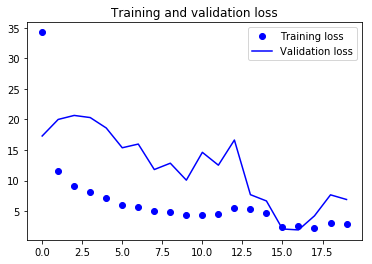

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### A first recurrent Model

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

#### Using an LSTM layer

In [13]:
model = Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

model.compile(loss="mae", optimizer="adam")
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

W0728 00:53:22.441256 140057907312512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 2s - loss: 10.3858 - val_loss: 9.0922
Epoch 2/20
 - 1s - loss: 9.4016 - val_loss: 8.5092
Epoch 3/20
 - 1s - loss: 8.8754 - val_loss: 8.4909
Epoch 4/20
 - 1s - loss: 8.5861 - val_loss: 8.1789
Epoch 5/20
 - 1s - loss: 8.0049 - val_loss: 7.7703
Epoch 6/20
 - 1s - loss: 7.5033 - val_loss: 7.3523
Epoch 7/20
 - 1s - loss: 7.1645 - val_loss: 7.1633
Epoch 8/20
 - 1s - loss: 6.8713 - val_loss: 6.7289
Epoch 9/20
 - 1s - loss: 6.3591 - val_loss: 6.9095
Epoch 10/20
 - 1s - loss: 6.1122 - val_loss: 6.7177
Epoch 11/20
 - 1s - loss: 5.8672 - val_loss: 7.1155
Epoch 12/20
 - 1s - loss: 6.2001 - val_loss: 6.5505
Epoch 13/20
 - 1s - loss: 5.5965 - val_loss: 6.9097
Epoch 14/20
 - 1s - loss: 5.5802 - val_loss: 6.5661
Epoch 15/20
 - 1s - loss: 5.5116 - val_loss: 7.8107
Epoch 16/20
 - 1s - loss: 5.3219 - val_loss: 7.3380
Epoch 17/20
 - 1s - loss: 5.0777 - val_loss: 6.7964
Epoch 18/20
 - 1s - loss: 5.1839 - val_loss: 5.7711
Epoch 19/20
 - 1s - los

#### The loss curves for validation and training

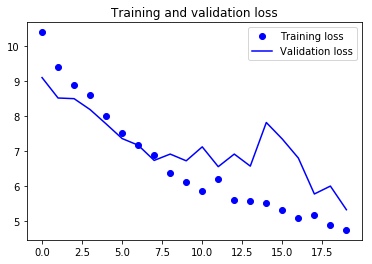

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So some of our validation losses are fluctuating and if we compare it with the basic machine learining technique, it performed much better. This shows the merits of having that as a baseline model in the first place: it turns out not to be so easy to outperform. Our basic technique contains already a lot of valuable information that a machine learning model does not have access to.

Now the question becomes, if there exists a simple, well-performing model to go from the data to the targets, why doesn't the model we are training find it and improve on it? Simply put: because the simple solution in not what our model is trying to look for. These networks are already complicated, when looking for a solution with a space of complicated models, the simple well-perofrming baseline might be unlearnable, even if it's technically part of the hypothesis space. This is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard coded to look for a specific kinf of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

Instead of an LSTM layer this time we will use the GRU layer, developed ny Cho et al. in 2014. GRU layers (which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [15]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 2s - loss: 10.9614 - val_loss: 10.0225
Epoch 2/20
 - 1s - loss: 9.3791 - val_loss: 9.2232
Epoch 3/20
 - 1s - loss: 8.8566 - val_loss: 8.7945
Epoch 4/20
 - 1s - loss: 8.4525 - val_loss: 8.5356
Epoch 5/20
 - 1s - loss: 7.9659 - val_loss: 8.3014
Epoch 6/20
 - 1s - loss: 7.5710 - val_loss: 7.9358
Epoch 7/20
 - 1s - loss: 7.1518 - val_loss: 7.6107
Epoch 8/20
 - 1s - loss: 6.7719 - val_loss: 7.3239
Epoch 9/20
 - 1s - loss: 6.3467 - val_loss: 7.2600
Epoch 10/20
 - 1s - loss: 5.8671 - val_loss: 6.5120
Epoch 11/20
 - 1s - loss: 5.4169 - val_loss: 5.8314
Epoch 12/20
 - 1s - loss: 4.8613 - val_loss: 5.3040
Epoch 13/20
 - 1s - loss: 4.4286 - val_loss: 4.9077
Epoch 14/20
 - 1s - loss: 4.0570 - val_loss: 4.5904
Epoch 15/20
 - 1s - loss: 3.5736 - val_loss: 3.6247
Epoch 16/20
 - 1s - loss: 3.2610 - val_loss: 3.6093
Epoch 17/20
 - 1s - loss: 2.9647 - val_loss: 2.7906
Epoch 18/20
 - 1s - loss: 2.7719 - val_loss: 2.7988
Epoch 19/20
 - 1s - lo

#### The loss curves for validation and training

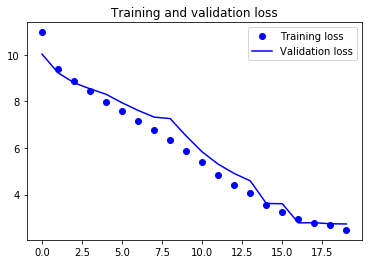

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Bidirectional RNNs
A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

#### Using a GRU Bidirectional layer

In [17]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 2s - loss: 10.2248 - val_loss: 9.5773
Epoch 2/20
 - 1s - loss: 9.1813 - val_loss: 9.0474
Epoch 3/20
 - 1s - loss: 8.6603 - val_loss: 8.6414
Epoch 4/20
 - 1s - loss: 8.0775 - val_loss: 8.2899
Epoch 5/20
 - 1s - loss: 7.5730 - val_loss: 7.9099
Epoch 6/20
 - 1s - loss: 7.0274 - val_loss: 7.5840
Epoch 7/20
 - 1s - loss: 6.5782 - val_loss: 7.2460
Epoch 8/20
 - 1s - loss: 6.1442 - val_loss: 6.9152
Epoch 9/20
 - 1s - loss: 5.6439 - val_loss: 6.8386
Epoch 10/20
 - 1s - loss: 5.2122 - val_loss: 6.3597
Epoch 11/20
 - 1s - loss: 4.8460 - val_loss: 5.5803
Epoch 12/20
 - 1s - loss: 4.5879 - val_loss: 5.1239
Epoch 13/20
 - 1s - loss: 4.2033 - val_loss: 4.8004
Epoch 14/20
 - 1s - loss: 3.7953 - val_loss: 4.6955
Epoch 15/20
 - 1s - loss: 3.4674 - val_loss: 4.3289
Epoch 16/20
 - 1s - loss: 3.2757 - val_loss: 4.0453
Epoch 17/20
 - 1s - loss: 3.0571 - val_loss: 3.7421
Epoch 18/20
 - 1s - loss: 2.7645 - val_loss: 3.5222
Epoch 19/20
 - 1s - los

#### The loss curves for validation and training

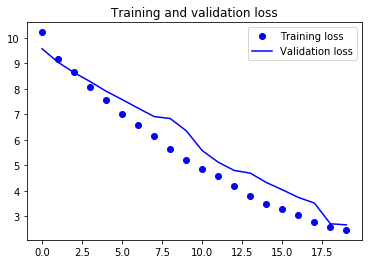

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Using a LSTM Bidirectional Layer

In [19]:
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32),
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 3s - loss: 10.7215 - val_loss: 10.2596
Epoch 2/20
 - 2s - loss: 9.8284 - val_loss: 9.6192
Epoch 3/20
 - 1s - loss: 9.3541 - val_loss: 9.1988
Epoch 4/20
 - 2s - loss: 8.9341 - val_loss: 8.9058
Epoch 5/20
 - 2s - loss: 8.6074 - val_loss: 8.6158
Epoch 6/20
 - 2s - loss: 8.2803 - val_loss: 8.3036
Epoch 7/20
 - 2s - loss: 7.8765 - val_loss: 7.9932
Epoch 8/20
 - 2s - loss: 7.4856 - val_loss: 7.6398
Epoch 9/20
 - 2s - loss: 7.0805 - val_loss: 7.1862
Epoch 10/20
 - 2s - loss: 6.6287 - val_loss: 6.9950
Epoch 11/20
 - 1s - loss: 6.2167 - val_loss: 6.5335
Epoch 12/20
 - 2s - loss: 5.6852 - val_loss: 5.9021
Epoch 13/20
 - 2s - loss: 5.2734 - val_loss: 5.8229
Epoch 14/20
 - 2s - loss: 4.8810 - val_loss: 4.9761
Epoch 15/20
 - 2s - loss: 4.4849 - val_loss: 4.5634
Epoch 16/20
 - 1s - loss: 4.1858 - val_loss: 4.3208
Epoch 17/20
 - 2s - loss: 3.8748 - val_loss: 3.7192
Epoch 18/20
 - 1s - loss: 3.6571 - val_loss: 3.3721
Epoch 19/20
 - 2s - lo

#### The loss curves for validation and training

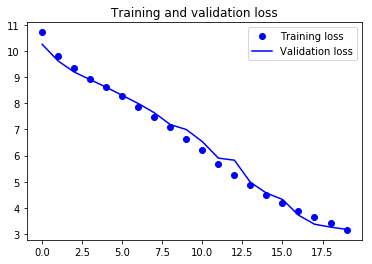

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Bidirectional RNNs are performing really good, the GRU Bidirectional RNN has really low training and validation losses. While the LSTM Bidirectional RNN has a bit more training and validation losses compared to the later but the delta between validation and training dataset is really low, hence this model is more consistent and won't overfit.

### Running the LSTM Bidirectional RNN on the test dataset to predict Air Temperature

In [21]:
prediction = model.predict(test_X, 
                    batch_size=128, 
                    verbose=2)
print(mean_absolute_error(test_y,prediction))

2.7095774217719217


### Other methods which didn't gave gove results!

We tried to increase the capacity of our network by increasing the number of units in our layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currecnlt powers Google translate algorithm is a stack of seven large LSTM layers -- that's HUGE! 

But in our case I tried adding Multiple LSTM and GRU layers, but as the model doesn't has a large amount of dataset the validation and training losses are diverging.

#### Stacking two GRU layers

In [22]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences = True,
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.GRU(64, activation="relu",
                    dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

W0728 00:59:31.409595 140057907312512 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 4s - loss: 9.5670 - val_loss: 8.9928
Epoch 2/20
 - 2s - loss: 7.6425 - val_loss: 8.1518
Epoch 3/20
 - 2s - loss: 6.5332 - val_loss: 7.1228
Epoch 4/20
 - 2s - loss: 6.1513 - val_loss: 6.7064
Epoch 5/20
 - 2s - loss: 5.9131 - val_loss: 7.5055
Epoch 6/20
 - 2s - loss: 5.5118 - val_loss: 8.7143
Epoch 7/20
 - 2s - loss: 5.1114 - val_loss: 8.9006
Epoch 8/20
 - 2s - loss: 4.8394 - val_loss: 11.3484
Epoch 9/20
 - 2s - loss: 4.6027 - val_loss: 10.8098
Epoch 10/20
 - 2s - loss: 4.3493 - val_loss: 12.0927
Epoch 11/20
 - 2s - loss: 4.2432 - val_loss: 11.8866
Epoch 12/20
 - 2s - loss: 4.0435 - val_loss: 12.4968
Epoch 13/20
 - 2s - loss: 3.9805 - val_loss: 9.5458
Epoch 14/20
 - 2s - loss: 3.9168 - val_loss: 11.2555
Epoch 15/20
 - 2s - loss: 3.7915 - val_loss: 10.8636
Epoch 16/20
 - 2s - loss: 3.7843 - val_loss: 9.5139
Epoch 17/20
 - 2s - loss: 3.6634 - val_loss: 10.9783
Epoch 18/20
 - 2s - loss: 3.6305 - val_loss: 10.7427
Epoch 19/20
 - 

#### The loss curves for validation and training

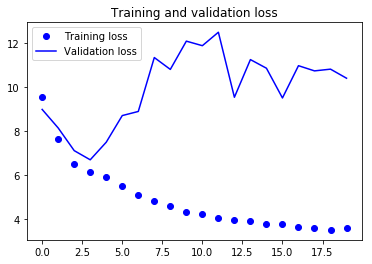

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Stacking two LSTM layers

In [0]:
model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences = True,
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.LSTM(64, activation="relu",
                    dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 6s - loss: 10.5317 - val_loss: 9.0571
Epoch 2/20
 - 1s - loss: 8.2212 - val_loss: 8.3959
Epoch 3/20
 - 1s - loss: 7.0340 - val_loss: 7.8657
Epoch 4/20
 - 1s - loss: 6.1831 - val_loss: 7.1685
Epoch 5/20
 - 1s - loss: 5.6113 - val_loss: 7.1767
Epoch 6/20
 - 1s - loss: 5.1878 - val_loss: 9.2307
Epoch 7/20
 - 1s - loss: 4.7616 - val_loss: 9.6416
Epoch 8/20
 - 1s - loss: 4.4297 - val_loss: 9.5291
Epoch 9/20
 - 1s - loss: 4.2424 - val_loss: 10.2368
Epoch 10/20
 - 1s - loss: 4.0086 - val_loss: 8.0595
Epoch 11/20
 - 1s - loss: 3.8941 - val_loss: 9.1157
Epoch 12/20
 - 1s - loss: 3.7898 - val_loss: 9.0975
Epoch 13/20
 - 1s - loss: 3.7471 - val_loss: 9.4218
Epoch 14/20
 - 1s - loss: 3.7507 - val_loss: 9.4364
Epoch 15/20
 - 1s - loss: 3.6967 - val_loss: 9.4360
Epoch 16/20
 - 1s - loss: 3.5906 - val_loss: 7.6270
Epoch 17/20
 - 1s - loss: 3.6615 - val_loss: 6.8432
Epoch 18/20
 - 1s - loss: 3.5964 - val_loss: 7.2458
Epoch 19/20
 - 1s - lo

#### The loss curves for validation and training

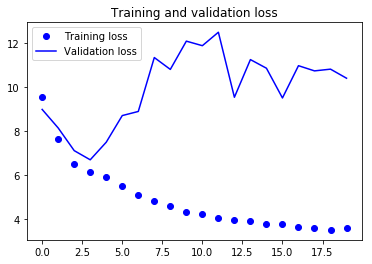

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Stacking one GRU and the other LSTM layer

In [25]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences = True,
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.LSTM(64, activation="relu",
                    dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_X, 
                    train_y,
                    epochs=20, 
                    batch_size=128, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2, shuffle=False)

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
 - 4s - loss: 9.6258 - val_loss: 9.2804
Epoch 2/20
 - 2s - loss: 8.0232 - val_loss: 9.4272
Epoch 3/20
 - 2s - loss: 6.8292 - val_loss: 8.7903
Epoch 4/20
 - 2s - loss: 6.1290 - val_loss: 9.0328
Epoch 5/20
 - 2s - loss: 5.7436 - val_loss: 8.4252
Epoch 6/20
 - 2s - loss: 5.4357 - val_loss: 9.9285
Epoch 7/20
 - 2s - loss: 5.1536 - val_loss: 9.2803
Epoch 8/20
 - 2s - loss: 4.8110 - val_loss: 11.1792
Epoch 9/20
 - 2s - loss: 4.5915 - val_loss: 10.3076
Epoch 10/20
 - 2s - loss: 4.4643 - val_loss: 11.6694
Epoch 11/20
 - 2s - loss: 4.3482 - val_loss: 11.8596
Epoch 12/20
 - 2s - loss: 4.2010 - val_loss: 11.1550
Epoch 13/20
 - 2s - loss: 4.1518 - val_loss: 11.0719
Epoch 14/20
 - 2s - loss: 4.0909 - val_loss: 11.7532
Epoch 15/20
 - 2s - loss: 4.1055 - val_loss: 11.8101
Epoch 16/20
 - 2s - loss: 4.0737 - val_loss: 12.0644
Epoch 17/20
 - 2s - loss: 3.9569 - val_loss: 11.7645
Epoch 18/20
 - 2s - loss: 3.9200 - val_loss: 10.6840
Epoch 19/20
 

#### The loss curves for validation and training

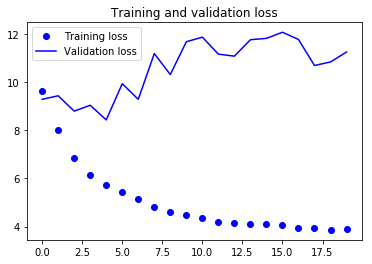

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()